In [1]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

# pd.set_option('display.min_row', 25)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

In [2]:
blocks = pd.read_csv('../data/processed/blocks_sev_score.csv', index_col=0)
intersections = pd.read_csv('../data/processed/intersections_sev_score.csv', index_col=0)
circles = pd.read_csv('../data/processed/circles_sev_score.csv', index_col=0)
crosswalks = pd.read_csv('../data/processed/crosswalks_sev_score.csv', index_col=0)

## Blocks

In [3]:
blocks.head()

,location,artdescript,speedlimit,segdir,oneway,surfacetype_1,nationhwysys,streettype,tranclass,trandescript,slope_pct,parkboulevard,year,count,total fatalities,total serious injuries,total evident injuries,total possible injuries,total vehicles,total pedestrians involved,total bicyclists involved,weigh_fatalities,weigh_serious,weigh_evident,weigh_possible,sev_score
0,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004
1,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2005.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000018
2,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2006.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013
3,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2007.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000018
4,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,Minor Arterial,25.0,NW,N,PCC,N,Downtown Neighborhood,1,PRINCIPAL TRANSIT ROUTE,4.0,N,2008.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000013


In [4]:
# check datatype
blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87248 entries, 0 to 87247
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   location                    87248 non-null  object 
 1   artdescript                 87248 non-null  object 
 2   speedlimit                  87248 non-null  float64
 3   segdir                      87248 non-null  object 
 4   oneway                      87248 non-null  object 
 5   surfacetype_1               87248 non-null  object 
 6   nationhwysys                87248 non-null  object 
 7   streettype                  87248 non-null  object 
 8   tranclass                   87248 non-null  int64  
 9   trandescript                87248 non-null  object 
 10  slope_pct                   87248 non-null  float64
 11  parkboulevard               87248 non-null  object 
 12  year                        87248 non-null  float64
 13  count                       872

In [5]:
blocks.columns

Index(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard', 'year', 'count',
       'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [6]:
blocks = blocks.groupby(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard']).sum().drop(columns='year').reset_index()

In [7]:
b_top10 = blocks.sort_values(by='count', ascending=False)[:10]

In [8]:
b_lowest = blocks.sort_values(by='count')[:10]

The top 10 blocks with the most count of collisions are all Principal Arterials

In [9]:
b_lowest['slope_pct'].mean()

3.8

In [10]:
b_top10['slope_pct'].mean()

1.4

In [11]:
b_top10['streettype']

13788        Urban Village Main
8034         Urban Village Main
8038         Urban Village Main
17427        Urban Village Main
23294    Urban Center Connector
8105         Urban Village Main
1505      Downtown Neighborhood
17460        Urban Village Main
15731        Urban Village Main
17433        Urban Village Main
Name: streettype, dtype: object

In [12]:
b_lowest['streettype']

23618    Urban Village Neighborhood Access
18833            Neighborhood Yield Street
18835    Urban Village Neighborhood Access
18837            Neighborhood Yield Street
18840              Minor Industrial Access
7765                Urban Center Connector
7762                Urban Center Connector
7760                     Industrial Access
18843            Neighborhood Yield Street
7758                     Industrial Access
Name: streettype, dtype: object

In [13]:
print(b_top10['location'])

13788                                N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N
8034                                           AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST
8038                                           AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST
17427                                   RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST
23294    WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP
8105                                               AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N
1505                                                 1ST AVE BETWEEN BLANCHARD ST AND BELL ST
17460                                RAINIER AVE S BETWEEN S HENDERSON ST AND S DIRECTOR N ST
15731                                      NE NORTHGATE WAY BETWEEN 3RD AVE NE AND 5TH AVE NE
17433                                 RAINIER AVE S BETWEEN S CHARLESTOWN ST AND S ANDOVER ST
Name: location, dtype: object


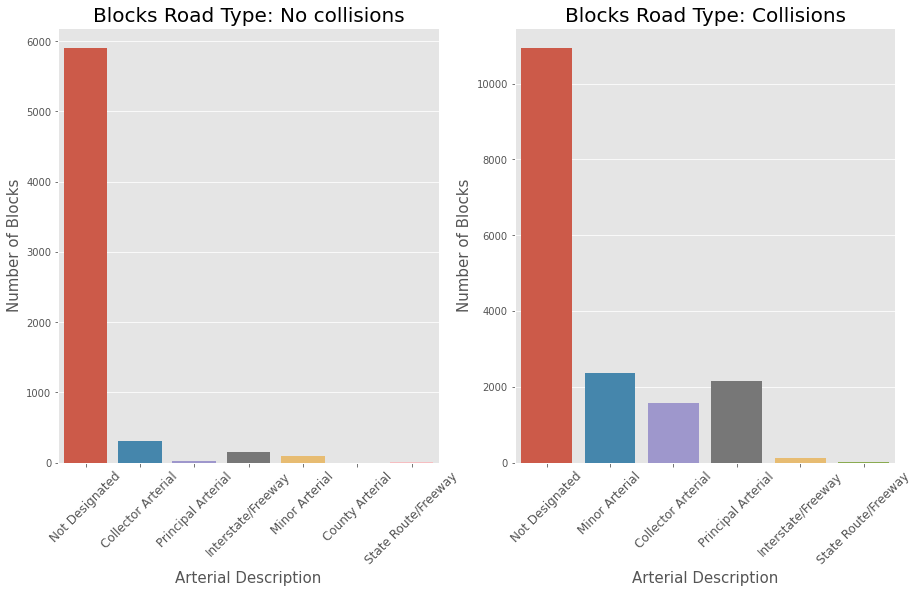

In [59]:
fig, axes = plt.subplots(1,2,figsize=(15,8))

sns.countplot(blocks[blocks['collisions'] == 0]['artdescript'], ax=axes[0])
axes[0].set_title('Blocks Road Type: No collisions', fontsize=20)
axes[0].set_ylabel('Number of Blocks', fontsize=15)
axes[0].set_xlabel('Arterial Description', fontsize=15)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, fontsize=12);

sns.countplot(blocks[blocks['collisions'] != 0]['artdescript'], ax=axes[1])
axes[1].set_title('Blocks Road Type: Collisions', fontsize=20)
axes[1].set_ylabel('Number of Blocks', fontsize=15)
axes[1].set_xlabel('Arterial Description', fontsize=15)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, fontsize=12);

plt.savefig('../reports/figures/blocks_artdescript.png')

In [26]:
blocks['artdescript'].value_counts()

Not Designated         16821
Minor Arterial          2452
Principal Arterial      2179
Collector Arterial      1874
Interstate/Freeway       262
State Route/Freeway       30
County Arterial            1
Name: artdescript, dtype: int64

In [14]:
b_top10.columns

Index(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard', 'count',
       'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [15]:
blocks['collisions'] = (blocks['sev_score'] > 0).astype(int)

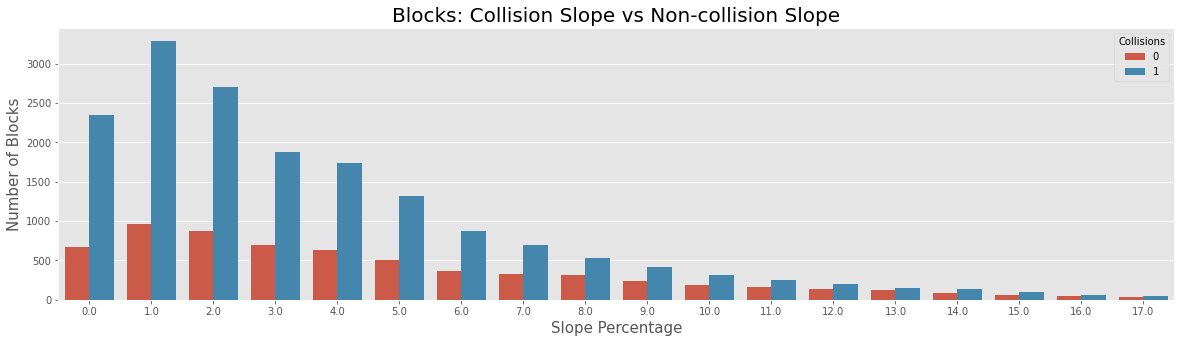

In [17]:
fig, ax = plt.subplots(figsize=(20,5))

sns.countplot(blocks[blocks['slope_pct'] < 18]['slope_pct'], hue=blocks['collisions'])
ax.set_title('Blocks: Collision Slope vs Non-collision Slope',  fontsize=20, color='black');
ax.set_ylabel('Number of Blocks', fontsize=15)
ax.set_xlabel('Slope Percentage',  fontsize=15)
ax.legend(labels=[0,1], title='Collisions', fontsize=10)

# plt.savefig('../reports/figures/blocks_slope.png')

In [21]:
len(blocks)

23619

In [24]:
(blocks['speedlimit'] < 30).sum() / len(blocks)

0.8657436809348406

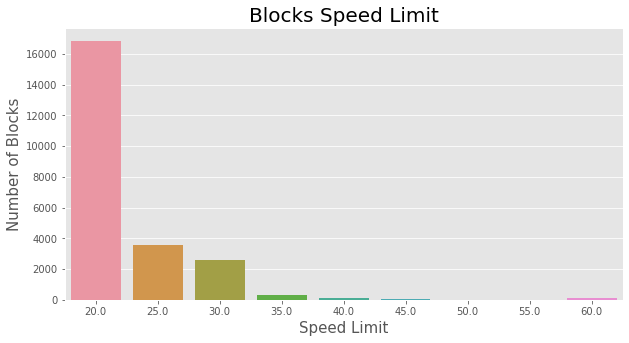

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.barplot(blocks[blocks['speedlimit'] > 0]['speedlimit'].value_counts().index, blocks[blocks['speedlimit'] > 0]['speedlimit'].value_counts().values)
ax.set_title('Blocks Speed Limit', fontsize=20, color='black')
ax.set_ylabel('Number of Blocks', fontsize=15)
ax.set_xlabel('Speed Limit', fontsize=15);

# plt.savefig('../reports/figures/blocks_splimit.png')

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

sns.countplot(blocks[blocks['speedlimit'] < 50][''], hue=blocks['collisions'])
ax.set_title('Blocks Speed Limit: Collision vs Non-collision',  fontsize=20, color='black');
ax.set_ylabel('Number of Blocks', fontsize=15)
ax.set_xlabel('Speed Limit',  fontsize=15)
ax.legend(labels=[0,1], title='Collisions', fontsize=10)

# plt.savefig('../reports/figures/blocks_slope.png')

In [ ]:
# about 72.5% of blocks have had a collision over the 16 year period

(blocks['collisions'] != 0).sum() / len(blocks['collisions'])

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(blocks[blocks['year'] != 0]['year']);

#### Remove time

In [ ]:
b_notime = blocks.drop(columns='year').copy()

In [ ]:
b_notime.head()

## Blocks with and without collisions

In [ ]:
b_nocol = blocks[blocks['sev_score'] == 0].drop(columns='year').groupby(['location', 'speedlimit', 'slope_pct', 'tranclass']).sum().reset_index()
b_yescol = blocks[blocks['sev_score'] != 0].drop(columns='year').groupby(['location', 'speedlimit', 'slope_pct', 'tranclass']).sum().reset_index()

#### No Collision Blocks

In [ ]:
b_nocol.describe()

In [ ]:
print('Average speedlimit for blocks with no incidents: ', b_nocol['speedlimit'].mean())
print('Average slope percent for blocks with no incidents: ', b_nocol['slope_pct'].mean())

#### Collision Blocks

In [ ]:
print('Average speedlimit for blocks with incidents: ', b_yescol['speedlimit'].mean())
print('Average slope percent for blocks with incidents: ', b_yescol['slope_pct'].mean())

In [ ]:
b_yescol.describe()

#### Plot both

In [ ]:
((b_nocol['slope_pct'].value_counts() / len(b_nocol['slope_pct'])*100).sort_index()).plot(kind='line')

In [ ]:
((b_yescol['slope_pct'].value_counts() / len(b_yescol['slope_pct'])*100).sort_index()).plot(kind='line')

In [ ]:
(b_yescol['slope_pct'].value_counts() / len(b_yescol['slope_pct'])*100).sort_index()

In [ ]:
b_yescol['slope_pct'].mean()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(25,5))

sns.countplot(b_nocol['slope_pct'], ax=axes[0], label='No collisions');
sns.countplot(b_yescol['slope_pct'], ax=axes[1], label='collisions');
axes[0].legend();
axes[1].legend();

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(25,5))

sns.countplot(b_nocol['speedlimit'], ax=axes[0], label='No collisions');
sns.countplot(b_yescol['speedlimit'], ax=axes[1], label='collisions');
axes[0].legend();
axes[1].legend();

## Intersections

In [ ]:
# about 84% of intersections have had a collision over the 16 year period

(intersections['year'] != 0).sum() / len(intersections['year'])

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(intersections['count']);

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(intersections[intersections['year'] != 0]['year']);

## Circles

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(circles['count']);

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

sns.countplot(circles[circles['year'] != 0]['year']);

In [ ]:
# about 77% of circles have had a collision over the 16 year period

(circles['year'] != 0).sum() / len(circles['year'])

## Crosswalks